In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
import math as m

# pytorch related stuf.. 
import torch
from torch.nn import Module 
import torch.nn as nn 
from torch.nn.functional import softmax 
from tqdm import tqdm 

/home/vigu/pyenvs/pytorch_latest/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def plot_imputed_values(df, ax1, colors) -> None:
    """
            Takes in a dataframe and spits out a figure named <fig_name>
            
            
    """
    # plt.rcParams['text.usetex'] = True

    marker_size = 15.0 
    alpha = 0.8

    #color_palatte = sns.color_palette("cubehelix",7)
    color_palatte = sns.color_palette("magma", 20)
    # colors = "blue" #df.labels.apply(lambda label: color_palatte[0])
    edge_color = "lightblue"# colors

    sns.scatterplot(x='R1', y='V1', data=df, ax=ax1, alpha=alpha, s=marker_size, edgecolor=edge_color, color=colors)


def plot_li_vs_others(df, fig_name="li_vs_others.png") -> None:
    """
        Takes in a dataframe and spits out a figure named <fig_name>
        
        
    """
    # plt.rcParams['text.usetex'] = True


    fig, ax1 = plt.subplots(figsize=(10,3))
    marker_size = 15.0
    alpha = 0.8

 #   color_palatte = sns.color_palette("bright",10)
#    marker_color_idx = 7
    marker_color = "grey"

    ax1.set_title('')
    sns.scatterplot(x='R1', y='V1', data=df, ax=ax1, alpha=alpha, s=marker_size, color=marker_color)
    ax1.set_xlabel(r"$R1$")
    ax1.set_ylabel(r"$V1$")

    return ax1

In [3]:
def density(xi_d, pis, mu_d, Ss_dd):
    # Multivariate normal density
    # f(x) = (1/2pi)^(p/2) * |Sigma|^(-1/2) * exp(-1/2 * (x - mu).T @ Sigma^(-1) @ (x - mu))
    p = xi_d.shape[0]
    leading_constant = (2 * np.pi) ** (-p / 2)
    xm = xi_d - mu_d
    xm = np.expand_dims(xm, axis=0)
    Ss_inv = np.linalg.inv(Ss_dd)
    res = (xm.transpose(1, 0, 2) @ Ss_inv).transpose(1, 0, 2)
    res = np.exp(-0.5 * (res * xm).sum(-1))
    res = pis * np.sqrt(np.linalg.det(Ss_inv)) * res * leading_constant
    return res

In [4]:
def conditional_mean_imputation(X: np.array, pis: np.array, mus: np.array, Ss: np.array):
    mis_idx = pd.DataFrame(X).isna().to_numpy()
    for i in range(X.shape[0]):
        xis = X[i,:]
        mis = mis_idx[i,:]
        xi_d = xis[~mis]
        mu_d = mus[:,~mis]
        mu_m = mus[:,mis]
        Ss_dd = Ss[:, ~mis][:,:,~mis]
        Ss_md = Ss[:, mis][:,:,~mis]
        Ss_mm = Ss[:, mis][:,:,mis]
        dd_diff = np.expand_dims(xi_d - mu_d, -1)
        lmatrix_term = Ss_md @ (np.linalg.inv(Ss_dd))
        mu_tildes = mu_m + (lmatrix_term @ dd_diff)[:,:,0]

        zigs = density(xi_d, pis, mu_d, Ss_dd)
        zigs = zigs/zigs.sum()
        zigs[0,-1] = 1 - zigs[0,:-1].sum()
        zigs = zigs.transpose()
        xi_m_imputed = (mu_tildes * zigs).sum(0)
        xis[mis] = xi_m_imputed
    return X

In [5]:
df = pd.read_csv("st4.csv")

In [6]:
df.shape

(69, 5)

In [7]:
df.sample(10)

,Unnamed: 0,R1,V1,R2,V2
41,2046,75.0,63.0,88.0,73.0
53,1013,113.0,NaN,NaN,NaN
43,2054,NaN,NaN,115.0,NaN
61,3047,NaN,NaN,130.0,195.0
4,4008,118.0,140.0,118.0,123.0
29,1057,108.0,103.0,90.0,100.0
15,4020,112.0,115.0,93.0,140.0
42,2050,93.0,NaN,NaN,NaN
9,4014,NaN,145.0,139.0,185.0
63,3053,64.0,45.0,82.0,53.0


In [8]:
df = df.iloc[1:,:]
df = df.iloc[:, 1:3]
df.columns = ["R1","V1"]

In [9]:
df.sample(10)

,R1,V1
52,127.0,138.0
40,NaN,NaN
63,64.0,45.0
46,NaN,NaN
34,90.0,NaN
16,133.0,168.0
56,NaN,NaN
67,105.0,138.0
62,NaN,NaN
8,115.0,153.0


### Histogram before power transform

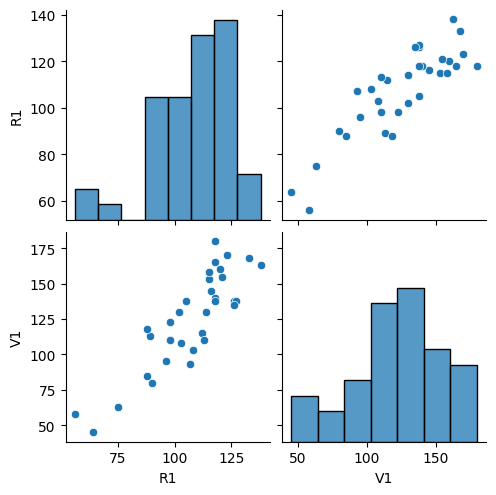

In [10]:
sns.pairplot(df)

### Box-Cox power transform

In [11]:
transformer = PowerTransformer(method="box-cox")
df_transform = transformer.fit_transform(df)
df_transform = pd.DataFrame(df_transform)
df_transform.columns = df.columns

### Plot after Box-Cox power transform, looks more normal like

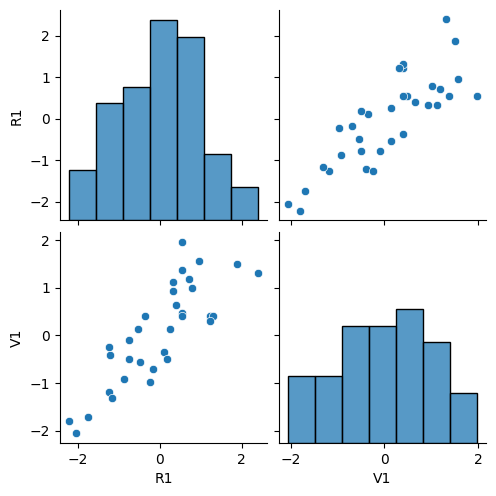

In [12]:
sns.pairplot(df_transform)

### Imputation before transformation

In [13]:
na_mask = df.isna().any(axis=1)
df_na = df.loc[na_mask,:].copy()
na_mask = df_na.isna().all(axis=1)
df_na = df_na.loc[~na_mask,:]
na_mask = df.isna().any(axis=1)
df_clean = df.loc[~na_mask,:].copy()

In [14]:
# Mixture model
Gs = range(2,12)
best_bic = float("inf")
best_G = None
best_model = None
for G in Gs:
    mm = GaussianMixture(n_components=G)
    # fit 
    mm.fit(df_clean.to_numpy())
    bic = mm.bic(df_clean.to_numpy())
    print(f"G: {G}, BIC: {bic}")
    if bic < best_bic:
        best_bic = bic
        best_G = G
        best_model = mm
print(f"Best G: {best_G}, Best BIC: {best_bic}")
mus = best_model.means_
ss = best_model.covariances_
pis = best_model.weights_

G: 2, BIC: 590.6258073894841
G: 3, BIC: 610.7123821561935
G: 4, BIC: 618.4885203171094
G: 5, BIC: 638.6088737918469
G: 6, BIC: 617.5074998221844
G: 7, BIC: 629.1843323488633
G: 8, BIC: 585.4564960756089
G: 9, BIC: 593.935359060823
G: 10, BIC: 542.3756357293901
G: 11, BIC: 559.949499894668
Best G: 10, Best BIC: 542.3756357293901


In [15]:
x_imputed_array = conditional_mean_imputation(df_na.copy().to_numpy(), pis, mus, ss)
df_imputed = pd.DataFrame(x_imputed_array)
df_imputed.columns = df_na.columns

### Imputation scatterplot before transformation, blue points are imputed

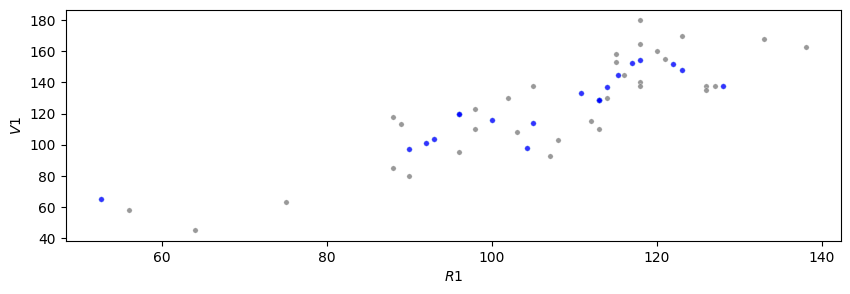

In [16]:
ax1 = plot_li_vs_others(df_clean)
plot_imputed_values(df_imputed, ax1, colors="blue")
plt.show()

### Data cleaning and imputation after transformation

In [17]:
na_mask = df_transform.isna().any(axis=1)
df_transform_na = df_transform.loc[na_mask,:].copy()
na_mask = df_transform.isna().all(axis=1)
df_transform_na = df_transform_na.loc[~na_mask,:]
na_mask = df_transform.isna().any(axis=1)
df_transform_clean = df_transform.loc[~na_mask,:].copy()

In [18]:
# Mixture model
Gs = range(2,12)
best_bic = float("inf")
best_G = None
best_model = None
for G in Gs:
    mm = GaussianMixture(n_components=G)
    # fit 
    mm.fit(df_transform_clean.to_numpy())
    bic = mm.bic(df_transform_clean.to_numpy())
    print(f"G: {G}, BIC: {bic}")
    if bic < best_bic:
        best_bic = bic
        best_G = G
        best_model = mm
print(f"Best G: {best_G}, Best BIC: {best_bic}")
mus = best_model.means_
ss = best_model.covariances_
pis = best_model.weights_

G: 2, BIC: 189.4916327209491
G: 3, BIC: 198.3783289725534
G: 4, BIC: 191.55448711723722
G: 5, BIC: 217.52914012029328
G: 6, BIC: 207.2866973839192
G: 7, BIC: 220.26057628003872
G: 8, BIC: 217.83448167910984
G: 9, BIC: 225.5228752668162
G: 10, BIC: 206.5535262627735
G: 11, BIC: 198.1800841056517
Best G: 2, Best BIC: 189.4916327209491


In [19]:
x_imputed_array = conditional_mean_imputation(df_transform_na.copy().to_numpy(), pis, mus, ss)
df_imputed = pd.DataFrame(x_imputed_array)
df_imputed.columns = df_transform_na.columns

### Inverse transformation

In [20]:
df_inverse_transform_clean = transformer.inverse_transform(df_transform_clean)
df_inverse_transform_clean = pd.DataFrame(df_inverse_transform_clean)
df_inverse_transform_clean.columns = df_transform_clean.columns
df_inverse_transform_na = transformer.inverse_transform(df_imputed)
df_inverse_transform_na = pd.DataFrame(df_inverse_transform_na)
df_inverse_transform_na.columns = df_imputed.columns

### Imputation scatterplot after transformation, red points are imputed

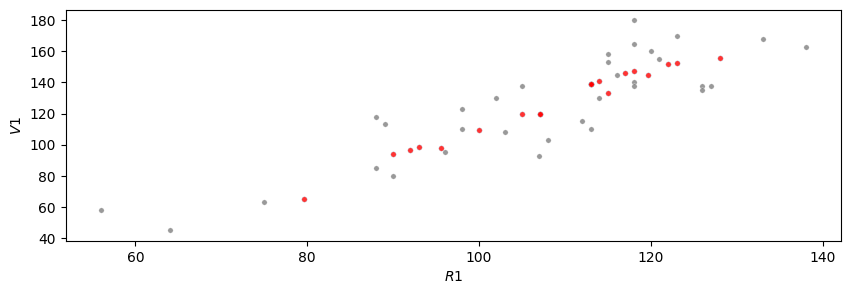

In [21]:
ax1 = plot_li_vs_others(df_inverse_transform_clean)
plot_imputed_values(df_inverse_transform_na, ax1, colors="red")
plt.show()

### Jointly training transformation and GMM using EM

In [22]:
class GaussianMixtureModel(nn.Module):
    """
        Class for Finite mixtures of Gaussian models. 
    """
   
    def __init__(self, G:int, data: torch.Tensor):
        """
            Constructor class for finite mixtures of linear models.  
        """
        
        if not isinstance(data, torch.Tensor):
            raise Exception("data is not of torch.Tensor type") 

        super(GaussianMixtureModel, self).__init__() 

        # define data 
        self.X = data

        # define constants. 
        self.n = data.shape[0] 
        self.G = G if G > 0 else exec("raise Exception('G has to be valid')") 
        self.p = self.X.shape[1]         

        # Parameter for transformation, small value of lambda may cause
        # loss to go nan initially, so multiply it with a constant
        self.lambdas = torch.rand(self.p, 1)

        # define actual parameters based on random chunking
        self.mus = torch.zeros(G, self.p)
        self.sigmas = torch.zeros(G, self.p, self.p)
        for i, xs in enumerate(torch.chunk(self.transform(self.X), self.G)):
            self.mus[i,:] = xs.mean(axis=0)
            self.sigmas[i,:,:] = torch.cov(xs.T)
        # define weights
        self.w = torch.rand(G,1)

        # latent variable matrix of dimension = n * G
        self.z = np.random.normal(size=(self.n, self.G))
        # Z_ij should sum up to one for all i's and a given j
        self.z = scipy.special.softmax(self.z, axis=1)
        self.z = torch.Tensor(self.z)

        # set gradients. 
        self.w.requires_grad = True
        self.mus.requires_grad = True
        self.sigmas.requires_grad = True
        self.lambdas.requires_grad = True

        self.lbfgs_optimizer = torch.optim.LBFGS([self.lambdas], max_iter=1, lr=0.01)

        self.leading_constant = - (self.p / 2) * torch.Tensor([2.0 * torch.pi]).log()
    
    def lbfgs_closure(self):
        self.lbfgs_optimizer.zero_grad()
        cost = self.objective_fn()
        cost.backward() # compute gradient. 
        return cost

    def compute_weights(self):
        """
            get mixing proportions. 
        """
        return softmax(self.w[:,0], dim=0)

    def transform(self, X):
        # Box-cox transform
        X_transform = torch.clone(X)
        for p in range(self.p):
            X_transform[:, p] = (X[:, p] ** self.lambdas[p] - 1) / self.lambdas[p]
        return X_transform
    
    def inverse_transform(self, X):
        # Inverse of box-cox transform
        X_inv_transform = torch.clone(X)
        for p in range(self.p):
            X_inv_transform[:, p] = ((X[:, p] * self.lambdas[p]) + 1) ** (1 / self.lambdas[p])
        return X_inv_transform

    def log_density(self):
        # Log of multivariate normal density
        # f(x) = (1/2pi)^(p/2) * |Sigma|^(-1/2) * exp(-1/2 * (x - mu).T @ Sigma^(-1) @ (x - mu)) * |Jacobian|
        # log(f(x))

        X_transform = self.transform(self.X)
        n = X_transform.shape[0]
        ldens = torch.zeros(n, self.G) 
        for j in range(G):
            Ss_inv = torch.linalg.inv(self.sigmas[j,:,:])
            leading_constant_1 = - 0.5 * torch.linalg.det(self.sigmas[j,:,:]).log()
            for i in range(n):
                xm = (X_transform[i,:] - self.mus[j,:]).unsqueeze(1)
                res = -0.5 * (xm.T @ Ss_inv @ xm)[0][0]
                res += self.leading_constant.squeeze() + leading_constant_1
                # Add log jacobian for box-cox transform
                res += (self.X[i, :].log().unsqueeze(0) @ (self.lambdas - 1))[0][0]
                ldens[i][j] = res
        return ldens

    def objective_fn(self):
        """
            Objective function to minimize on, 
            takes in an (n x d + 1) matrix with the response variable 
            in the first column 
        """
        
        # compute log densities. 
        dens = self.log_density().exp() 

        # get weights. 
        W = self.compute_weights() 
        
        return -((dens * W).sum(-1).log()).sum() 
        
    def train(self, lr=1e-3, max_iterations=1000): 
        """
            train using some gradient descent algorithm 
        """

        # define optimizer 
        optimizer = torch.optim.Adam([self.w,
                                      self.mus, 
                                      self.sigmas], lr=lr)
        # track loss 
        loss = np.zeros(max_iterations)
        tq_obj = tqdm(range(max_iterations), desc="Model Training")
       
        for it in tq_obj:
            optimizer.zero_grad() 
            cost = self.objective_fn(self.X)
            cost.backward() # compute gradient. 
            optimizer.step() 

            loss[it] = cost.data.cpu().numpy() 
            
            # log the loss. 
            if it % 100 == 0:    
                tqdm.write(f"Loss: {loss[it]}  λ: {optimizer.param_groups[0].get('lr')}")

    def BIC(self):
        """
            Calculates the Bayesian Information Criterion for model performance comparisons.
        """

        # calculate number of parameters. 
        rho = self.mus.numel() + self.sigmas.numel() + self.w.numel()
        bic = self.objective_fn() * (-2.0) - rho * m.log(self.X.shape[0])
        return float(bic.detach())

    def Estep(self):
        """
            Computes the expectation step using parameters for X ,y
        """
        
        with torch.no_grad():
            dens = self.log_density().exp()

            W = self.compute_weights() 
            dens = dens * W
            
            d_sum = dens.sum(-1).unsqueeze(-1)
            dens = dens / d_sum 

        self.z = dens

    def Mstep(self):
        """
        Estimate parameters to maximize likelihood
        """
        X_transform = self.transform(self.X)
        with torch.no_grad():
            self.w = (self.z.sum(axis=0)/self.z.shape[0]).unsqueeze(-1)
            for g in range(self.G):
                self.mus[g,:] = (self.z[:,g].unsqueeze(-1) * X_transform).sum(0) / self.z[:,g].sum()
            for g in range(self.G):
                xm = X_transform - self.mus[g,:]
                self.sigmas[g,:,:] = ((xm.T * self.z[:,g]) @ xm) / self.z[:,g].sum()
        # Estimate lambdas using LBFGS
        self.lbfgs_optimizer.step(self.lbfgs_closure) 

    def train_EM(self, max_iter=10):
        """Run EM algorithm"""
        for it in tqdm(range(max_iter), desc="Running EM algo"):
            self.Estep()
            self.Mstep()

        print(f"Loss: {self.objective_fn()}")

### Run it now!

In [23]:
na_mask = df.isna().any(axis=1)
df_na = df.loc[na_mask,:].copy()
na_mask = df.isna().all(axis=1)
df_na = df_na.loc[~na_mask,:]
na_mask = df.isna().any(axis=1)
df_clean = df.loc[~na_mask,:].copy()

In [24]:
# Mixture model
X = df_clean.copy().to_numpy()
X = torch.Tensor(X)
Gs = range(2, 6)
best_bic = float("inf")
best_G = None
best_model = None
for G in Gs:
    mm = GaussianMixtureModel(G=G, data=X)
    # fit 
    mm.train_EM(max_iter=50)
    bic = -mm.BIC()
    print(f"G: {G}, BIC: {bic}")
    if bic < best_bic:
        best_bic = bic
        best_G = G
        best_model = mm
print(f"Best G: {best_G}, Best BIC: {best_bic}")

Running EM algo: 100%|██████████| 50/50 [00:00<00:00, 71.31it/s]


Loss: 280.0360107421875
G: 2, BIC: 609.0231323242188


Running EM algo: 100%|██████████| 50/50 [00:01<00:00, 46.84it/s]


Loss: 276.073486328125
G: 3, BIC: 625.5736083984375


Running EM algo: 100%|██████████| 50/50 [00:01<00:00, 36.17it/s]


Loss: 269.29302978515625
G: 4, BIC: 636.48828125


Running EM algo: 100%|██████████| 50/50 [00:01<00:00, 28.55it/s]


Loss: 255.72012329101562
G: 5, BIC: 633.8179931640625
Best G: 2, Best BIC: 609.0231323242188


In [25]:
mus = best_model.mus.detach().numpy()
sigmas = best_model.sigmas.detach().numpy()
w = best_model.w.numpy().squeeze()

In [26]:
x_array_na = best_model.transform(torch.Tensor(df_na.to_numpy())).detach().numpy()
x_imputed_array = conditional_mean_imputation(x_array_na, w, mus, sigmas)
x_imputed_array_inv_transform = best_model.inverse_transform(torch.Tensor(x_imputed_array)).detach().numpy()

In [27]:
df_imputed = pd.DataFrame(x_imputed_array_inv_transform)
df_imputed.columns = df_transform_na.columns

### Imputation after joint training using EM, brown points are imputed

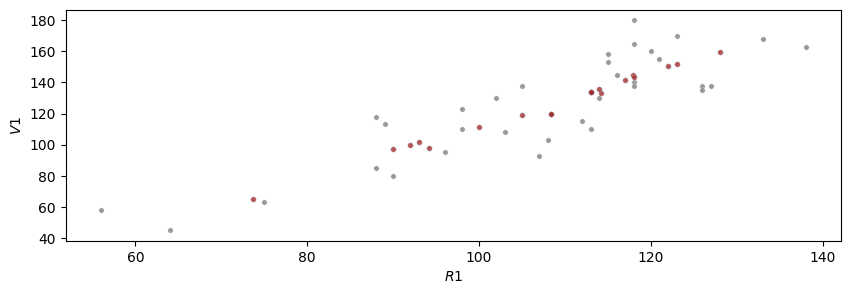

In [28]:
ax1 = plot_li_vs_others(df_clean)
plot_imputed_values(df_imputed, ax1, colors="brown")
plt.show()

### Comments

- We can clearly see the brown and red imputations (after transformation to normality) are much better than the blue imputation (without transformation)

- This is because in the blue imputation the assumption of normality for Gaussian Mixture model was not satisfied

- In the blue imputation, there are much more outliers and the imputed points don't seem to be as linear as brown and red plots

- From the imputation we can see that there is a linear trend between R1 and V1 which is expected, since increasing R1 score means better literacy which means better verbal skills, so higher V1